In [12]:
import datetime
import time as time_module
import sys
import os 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt



try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'
path_save_pickled = '../../data'
rerun = False

In [13]:

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
# date_data_end   = cov19.get_last_date(confirmed_cases)
date_data_end = datetime.datetime(2020,4,21)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]
if rerun:

    traces = []
    models = []
    for num_change_points in range(4):
        model = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                            change_points_list = change_points[:num_change_points],
                                            date_begin_simulation = date_begin_sim,
                                            num_days_sim = num_days_sim,
                                            diff_data_sim = diff_data_sim,
                                            N = 83e6,
                                            priors_dict=None,
                                            weekends_modulated=True,
                                            weekend_modulation_type = 'abs_sine')
        models.append(model)
        traces.append(pm.sample(model=model, init='advi', draws=4000, tune=1000))


    pickle.dump([models, traces], open(path_save_pickled + 'SIR_3scenarios_with_sine.pickled', 'wb'))

else: 
    models, traces = pickle.load(open(path_save_pickled + 'SIR_3scenarios_with_sine.pickled', 'rb'))

    

Cases yesterday (2020-04-21T00:00:00): 148291 and day before yesterday: 147065


In [21]:
exec(open('figures_revised.py').read())

148197.59055329964


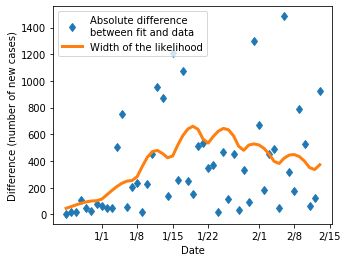

In [15]:
trace = traces[3]
fig, ax = plt.subplots(figsize=(5,4))
time = np.arange(-len(cases_obs)+1, 0)
mpl_dates = conv_time_to_mpl_dates(time) 
ax.plot(mpl_dates, np.abs(np.median(trace.new_cases[:, :num_days_data], axis=0) - np.diff(cases_obs)), 
        'd', markersize=6,
         label='Absolute difference\n'
               'between fit and data')
ax.plot(mpl_dates, np.sqrt(np.median(trace.new_cases[:, :num_days_data], axis=0))*np.median(trace.sigma_obs, axis=0),
         label='Width of the likelihood', lw=3)
ax.set_ylabel('Difference (number of new cases)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
print(np.median(np.sum(trace.new_cases[:, :num_days_data], axis=1)+ trace.I_begin))
#plt.tight_layout()
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))


/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2037: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2037: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2037: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


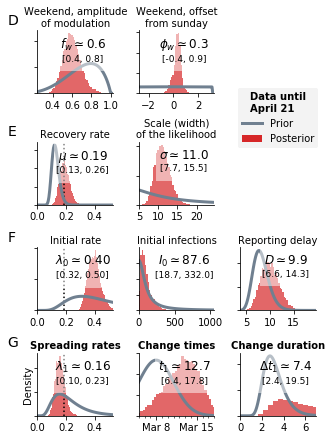

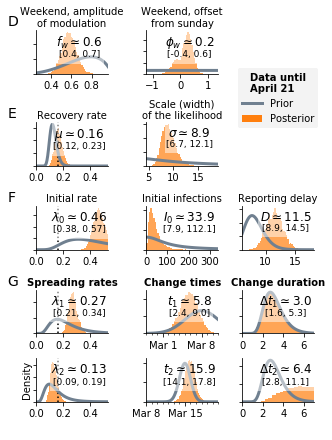

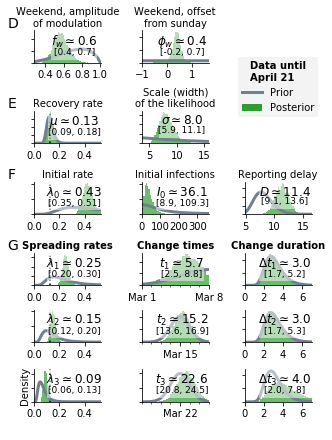

In [23]:
create_figure_distributions(models[1], traces[1],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:red',
                              num_changepoints=1, xlim_tbegin=7, save_to = path_to_save +'Fig_S2')
create_figure_distributions(models[2], traces[2],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:orange',
                              num_changepoints=2, xlim_tbegin=7, save_to = path_to_save +'Fig_4')
create_figure_distributions(models[3], traces[3],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, save_to = path_to_save + 'Fig_S4')

(<Figure size 288x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1418383e90>,
       dtype=object))

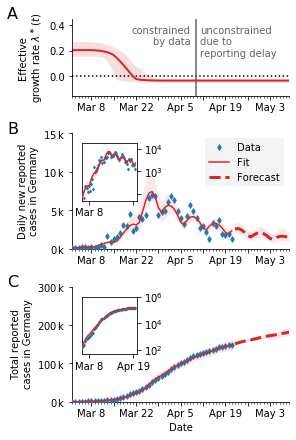

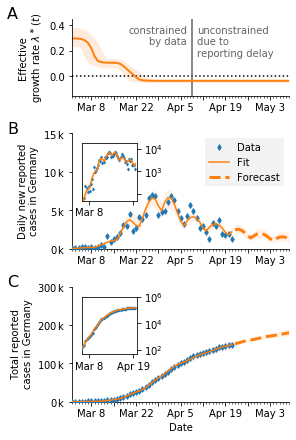

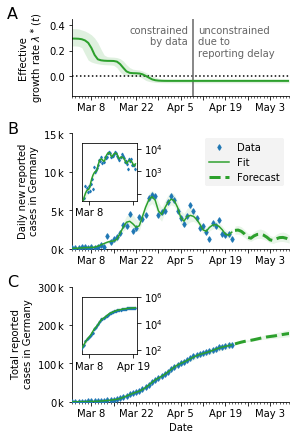

In [17]:
create_figure_timeseries(traces[1], 'tab:red',
                       plot_red_axis=True, save_to=path_to_save + 'Fig_S1')
create_figure_timeseries(traces[2], 'tab:orange',
                       plot_red_axis=True, save_to=path_to_save + 'Fig_3')
create_figure_timeseries(traces[3], 'tab:green',
                       plot_red_axis=True, save_to=path_to_save + 'Fig_S3')

In [18]:
print('\n0 step model\n')
print(pm.loo(traces[0], models[0]))

print('\n1 step model\n')
print(pm.loo(traces[1], models[1]))

print('\n2 steps model\n')
print(pm.loo(traces[2], models[2]))

print('\n3 steps model\n')
print(pm.loo(traces[3], models[3]))


0 step model

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   927.48     9.53
p_loo      8.31        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


1 step model

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   819.42    15.62
p_loo     13.46        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       51  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


2 steps model

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   795.71    17.02
p_loo     12.53        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       51  100.0%
 (0.5, 0.7]   (o

In [32]:
for i in range(4):
    print(f"\nnumber of changepoints: {i}")
    for j in range(i+1):
        print(f'lambda* {j}')   
        print(print_median_CI(traces[i][f"lambda_{j}"] - traces[i].mu, prec=2))


number of changepoints: 0
lambda* 0
Median: 0.03
CI: [0.01, 0.05]

number of changepoints: 1
lambda* 0
Median: 0.21
CI: [0.16, 0.27]
lambda* 1
Median: -0.03
CI: [-0.05, -0.02]

number of changepoints: 2
lambda* 0
Median: 0.30
CI: [0.23, 0.38]
lambda* 1
Median: 0.11
CI: [0.07, 0.14]
lambda* 2
Median: -0.03
CI: [-0.05, -0.02]

number of changepoints: 3
lambda* 0
Median: 0.30
CI: [0.24, 0.37]
lambda* 1
Median: 0.12
CI: [0.09, 0.15]
lambda* 2
Median: 0.02
CI: [0.00, 0.05]
lambda* 3
Median: -0.03
CI: [-0.05, -0.02]
